In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import numpy as np
import sys
import pandas as pd
import scipy.io as sio
import seaborn as sns
import tensorly as tl
from tensorly.decomposition import parafac
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, r2_score

In [3]:
sys.path.append("../")
from src.data_processing import DataProcessing
from src.multi_bloc_reg import MultiBlocReg

In [ ]:
df_mat = sio.loadmat("../Acar_data/EEM_NMR_LCMS.mat")
df_cts = concentrations = pd.read_csv(
    "../Acar_data/concentrations.txt", sep=r"\s+", index_col=0
)


dp = DataProcessing(df_mat, df_cts)
X_eem, X_nmr, X_lcms = dp.get_processed_data()

Extracted EEM data with shape (28, 251, 21)
Extracted 3-way NMR data with shape (28, 13324, 8)
Extracted LCMS data with shape (28, 168)


# PARAFAC


### Simple test on arbitrary rank values


In [ ]:
bloc_reg = MultiBlocReg(X_eem, X_nmr, X_lcms, Y=df_cts.values)
ranks = {"X_eem": 3, "X_nmr": 3, "X_lcms": 5}

X_all = bloc_reg.CPD(ranks)

df_fused = pd.DataFrame(
    data=X_all,
    columns=[f"EEM_{i}" for i in range(ranks["X_eem"])]
    + [f"NMR_{i}" for i in range(ranks["X_nmr"])]
    + [f"LCMS_{i}" for i in range(ranks["X_lcms"])],
)
df_fused.head(3)

X_eem : (28, 251, 21)) -> (28,3)
X_nmr : (28, 13324, 8)) -> (28,3)
X_lcms : (28, 168)) -> (28,5)


,EEM_0,EEM_1,EEM_2,NMR_0,NMR_1,NMR_2,LCMS_0,LCMS_1,LCMS_2,LCMS_3,LCMS_4
0,638.250248,41554.856346,-326.491362,2.771124e+06,1.123300e+06,614127.123690,10235.584220,-7136.174505,-4643.342190,856.156766,-785.105793
1,40904.391632,-4972.918327,-1914.485786,-4.694768e+05,3.239290e+04,-164881.711496,-13954.243357,2954.078675,-6345.742206,-432.799853,-694.762541
2,256.635381,4473.563479,89439.454508,2.266350e+05,4.227142e+05,-57268.222904,-13407.111172,-819.118841,6149.323188,408.030989,-538.782346


In [ ]:
Y = df_cts.values
print(f"Shape des concentrations (y): {Y.shape}")

y = Y[:, 2]

# Standardisation et régression Ridge
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

alphas = np.logspace(-3, 3, 100)
model = RidgeCV(alphas=alphas, cv=5)

# Validation croisée
scores_r2 = cross_val_score(model, X_scaled, y, cv=5, scoring="r2")
scores_rmse = cross_val_score(
    model, X_scaled, y, cv=5, scoring="neg_root_mean_squared_error"
)
scores_mae = cross_val_score(
    model, X_scaled, y, cv=5, scoring="neg_mean_absolute_error"
)
print(f"MAE moyen en validation croisée : {-scores_mae.mean():.4f}")
print(f"RMSE moyen en validation croisée : {-scores_rmse.mean():.4f}")
print(f"R² moyen en validation croisée : {scores_r2.mean():.4f}")

Shape des concentrations (y): (28, 5)
MAE moyen en validation croisée : 0.2842
RMSE moyen en validation croisée : 0.3361
R² moyen en validation croisée : 0.9457


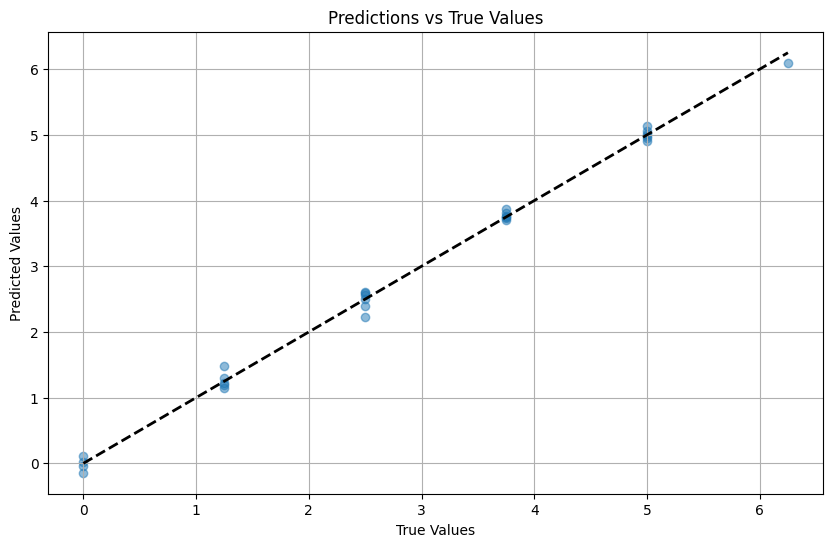

In [ ]:
# Plot predictions Vs true values
import matplotlib.pyplot as plt

model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs True Values")
plt.grid()
plt.show()

### Evaluation of the optimal rank for PARAFAC


In [ ]:
# Let's try to see the impact of the different ranks on the model
rank_grid = {
    "X_eem": [2, 4, 6, 8, 10],
    "X_nmr": [2, 4, 6, 8, 10],
    "X_lcms": [2, 4, 6, 8, 10],
}

best_combo, best_rmse, results = bloc_reg.rank_grid_search_rmse_with_plots(
    y=Y, rank_grid=rank_grid
)

In [59]:
rms = np.array([rmse for r, rmse in results])
eem = np.array([r["X_eem"] for r, rmse in results])
nmr = np.array([r["X_nmr"] for r, rmse in results])
lcms = np.array([r["X_lcms"] for r, rmse in results])

df_rank_res = pd.DataFrame({"X_eem": eem, "X_nmr": nmr, "X_lcms": lcms, "RMSE": rms})

In [ ]:
from src.utils import plot_3d_surface

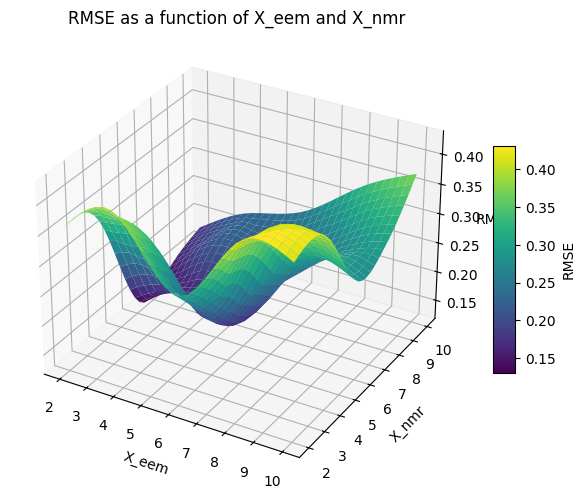

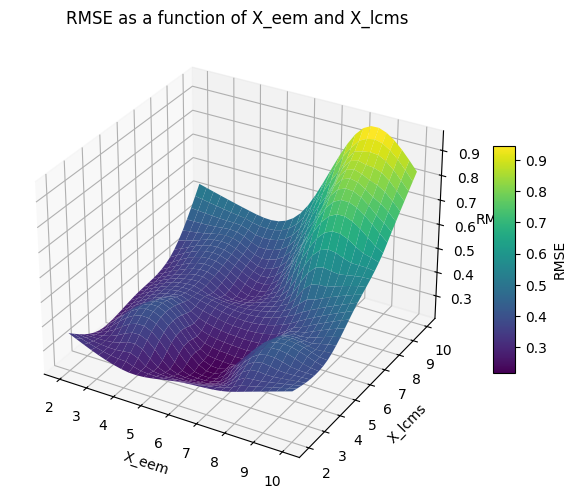

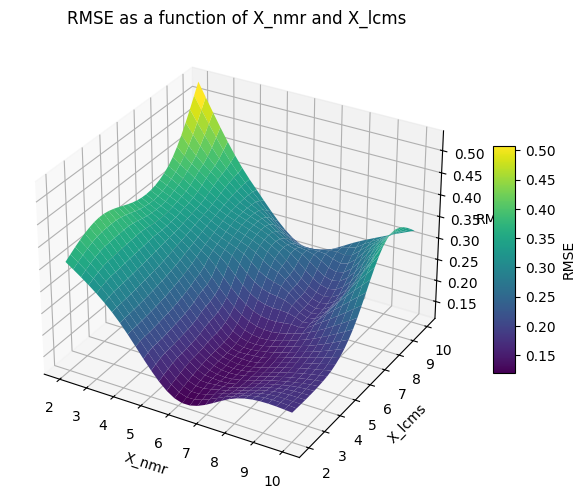

In [61]:
plot_3d_surface(
    df_rank_res["X_eem"],
    df_rank_res["X_nmr"],
    df_rank_res["RMSE"],
    xlabel="X_eem",
    ylabel="X_nmr",
    title="RMSE as a function of X_eem and X_nmr",
)

plot_3d_surface(
    df_rank_res["X_eem"],
    df_rank_res["X_lcms"],
    df_rank_res["RMSE"],
    xlabel="X_eem",
    ylabel="X_lcms",
    title="RMSE as a function of X_eem and X_lcms",
)
plot_3d_surface(
    df_rank_res["X_nmr"],
    df_rank_res["X_lcms"],
    df_rank_res["RMSE"],
    xlabel="X_nmr",
    ylabel="X_lcms",
    title="RMSE as a function of X_nmr and X_lcms",
)

In [63]:
best_combo, best_rmse

({'X_eem': 2, 'X_nmr': 6, 'X_lcms': 2}, np.float64(0.11989671586734103))

# Tuning model on the final data


In [65]:
from src.model_selector import RegressionModelSelector

In [ ]:
bloc_reg = MultiBlocReg(X_eem, X_nmr, X_lcms, Y=df_cts.values)
ranks = best_combo

X_all = bloc_reg.CPD(ranks)

X_eem : (28, 251, 21)) -> (28,2)
X_nmr : (28, 13324, 8)) -> (28,6)
X_lcms : (28, 168)) -> (28,2)


,EEM_0,EEM_1,NMR_0,NMR_1,NMR_2,NMR_3,NMR_4,NMR_5,LCMS_0,LCMS_1
0,5916.337932,5363.126218,139326.649370,104641.774621,91753.920470,376678.933158,43887.269819,148290.434200,10235.584220,-7136.174505
1,39128.639559,-3219.576995,130107.128255,151915.204854,93220.136492,42327.323648,90198.090567,57873.723384,-13954.243357,2954.078675
2,-155.150656,86695.757957,4197.542731,56594.342908,5892.709779,-20433.345344,-115814.466018,-8377.857660,-13407.111172,-819.118841


In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_all, Y, test_size=0.2, random_state=42
)  # 80% train, 20% test

In [ ]:
# Create the model selector
selector = RegressionModelSelector(n_iter=50, cv=5)

y_train = Y_train[:, 4]  # Select the target variable (e.g., the third column)

# Fit all models and find the best one
selector.fit(X_train, y_train)

# Print results table
print("\nResults Summary:")
print(selector.get_results_df())

# Get the best model and its name
best_model = selector.get_best_model()
best_model_name = selector.get_best_model_name()
print(f"Selected best model: {best_model_name}")

# Make predictions with the best model
y_pred = selector.predict(X_test)  # If you have a test set


Tuning Linear...
  Linear - RMSE: 0.1330, MAE: 0.1116, R²: 0.9917, Time: 0.01 sec

Tuning Ridge...
  Ridge - RMSE: 0.1609, MAE: 0.1299, R²: 0.9882, Time: 0.06 sec

Tuning Lasso...
  Lasso - RMSE: 0.2377, MAE: 0.2153, R²: 0.9761, Time: 0.06 sec

Tuning ElasticNet...
  ElasticNet - RMSE: 0.1952, MAE: 0.1684, R²: 0.9855, Time: 0.06 sec

Tuning SVR...
  SVR - RMSE: 0.1498, MAE: 0.1260, R²: 0.9908, Time: 0.07 sec

Tuning RandomForest...


/opt/homebrew/Caskroom/miniconda/base/envs/amda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/amda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/amda/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/amda/lib/python3.12/site-package

  RandomForest - RMSE: 0.8258, MAE: 0.7682, R²: 0.7426, Time: 3.49 sec

Tuning GradientBoosting...
  GradientBoosting - RMSE: 0.6022, MAE: 0.5049, R²: 0.7855, Time: 1.87 sec

Best model: Linear with RMSE: 0.1330

Results Summary:
              Model      RMSE       MAE        R²  Training Time (s)
0            Linear  0.132983  0.111594  0.991676           0.007498
4               SVR  0.149752  0.125988  0.990804           0.074441
1             Ridge  0.160911  0.129900  0.988241           0.057828
3        ElasticNet  0.195228  0.168402  0.985538           0.057446
2             Lasso  0.237700  0.215341  0.976143           0.059463
6  GradientBoosting  0.602157  0.504883  0.785519           1.870747
5      RandomForest  0.825815  0.768229  0.742566           3.492951
Selected best model: Linear


/Users/ilyes/Documents/CS/3A/SDI/AMDA/JODA_Multivariate_Analysis/notebooks/../src/model_selector.py:326: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(
/Users/ilyes/Documents/CS/3A/SDI/AMDA/JODA_Multivariate_Analysis/notebooks/../src/model_selector.py:333: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(
/Users/ilyes/Documents/CS/3A/SDI/AMDA/JODA_Multivariate_Analysis/notebooks/../src/model_selector.py:340: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(
/Users/ilyes/Documents/CS/3A/SDI/AMDA/JODA_Multivariate_Analysis/notebooks/../src/model_selector.py:347: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

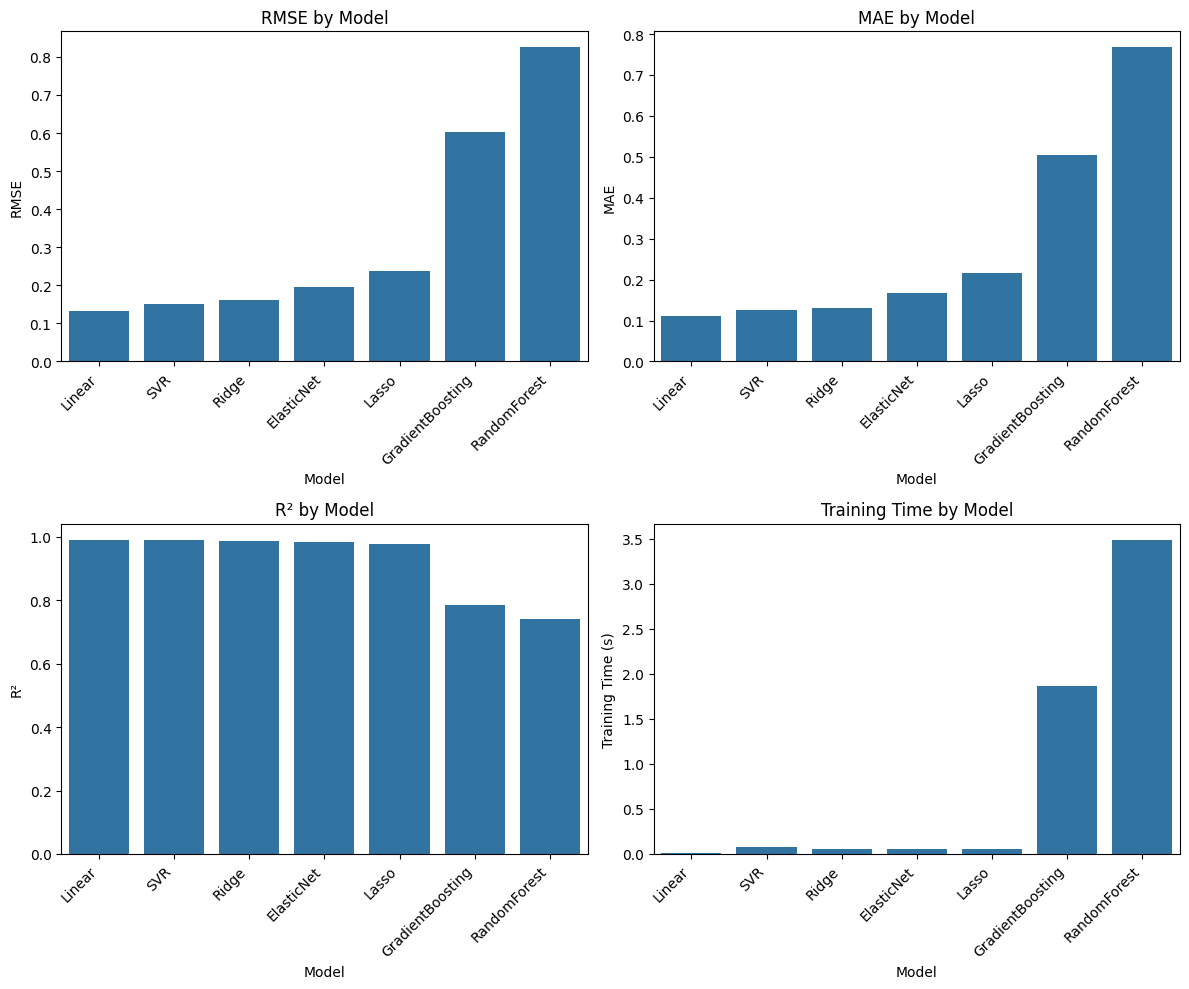

In [93]:
# Visualize results
selector.plot_results()
plt.show()

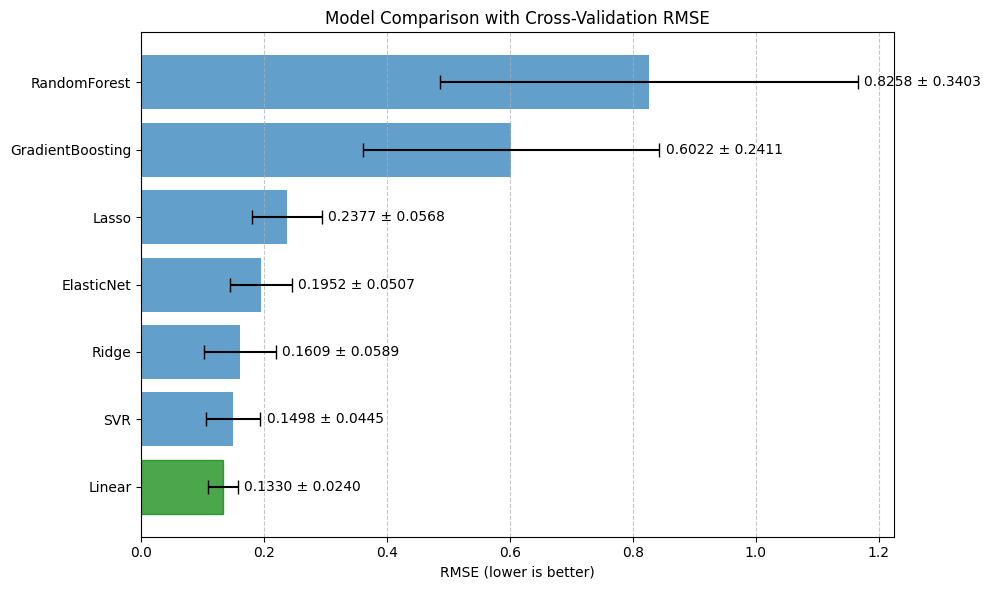

In [94]:
selector.plot_model_comparison()
plt.show()